In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [7]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

# 线性回归 & 五折交叉验证 & 模拟真实业务

In [8]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

## 简单建模

In [9]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

In [12]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416418773),
 ('v_8', 700675.5609398658),
 ('v_9', 170630.27723220887),
 ('v_7', 32322.66193201985),
 ('v_12', 20473.6707969639),
 ('v_3', 17868.079541497777),
 ('v_11', 11474.938996701725),
 ('v_13', 11261.764560015463),
 ('v_10', 2683.9200906023975),
 ('gearbox', 881.8225039247513),
 ('fuelType', 363.9042507215941),
 ('bodyType', 189.60271012070683),
 ('city', 44.94975120523033),
 ('power', 28.553901616752416),
 ('brand_price_median', 0.5103728134078794),
 ('brand_price_std', 0.4503634709263301),
 ('brand_amount', 0.14881120395065628),
 ('brand_price_max', 0.0031910186703119504),
 ('SaleID', 5.355989919853205e-05),
 ('train', 2.7008354663848877e-07),
 ('offerType', -2.230750396847725e-06),
 ('seller', -3.391294740140438e-06),
 ('brand_price_sum', -2.1750068681875342e-05),
 ('name', -0.0002980012713119153),
 ('used_time', -0.002515894332887234),
 ('brand_price_average', -0.4049048451011269),
 ('brand_price_min', -2.2467753486885997),
 ('power_bin', -34.42064411726994)

In [13]:
from matplotlib import pyplot as plt

In [15]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


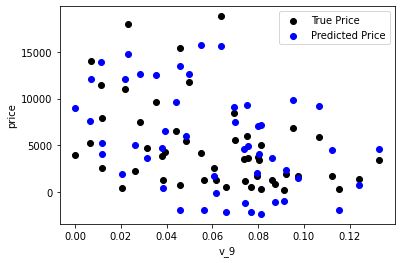

In [16]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


<AxesSubplot:xlabel='price', ylabel='Density'>

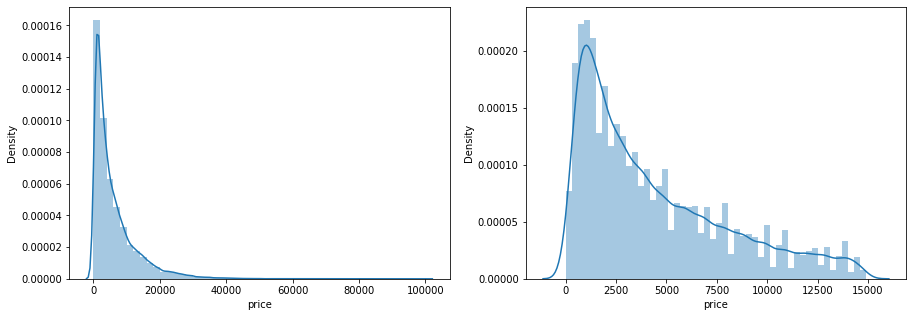

In [17]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [18]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


<AxesSubplot:xlabel='price', ylabel='Density'>

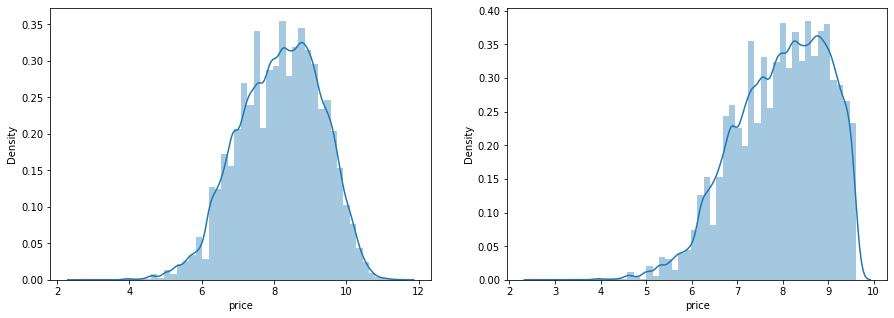

In [19]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [20]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074540765172


[('v_9', 8.052411882896202),
 ('v_5', 5.764248312434396),
 ('v_12', 1.61820668213206),
 ('v_1', 1.4798302891130295),
 ('v_11', 1.166901461767154),
 ('v_13', 0.9404706048573077),
 ('v_7', 0.7137294893555521),
 ('v_3', 0.6837865348596734),
 ('v_0', 0.008500528125817542),
 ('power_bin', 0.008497967211031446),
 ('gearbox', 0.00792237767082664),
 ('fuelType', 0.006684768364455499),
 ('bodyType', 0.004523520658197704),
 ('power', 0.0007161896138875891),
 ('brand_price_min', 3.334353058968063e-05),
 ('brand_amount', 2.897879991771903e-06),
 ('brand_price_median', 1.257111507945175e-06),
 ('brand_price_std', 6.659132501069285e-07),
 ('brand_price_max', 6.194957266234617e-07),
 ('brand_price_average', 5.999434780782674e-07),
 ('SaleID', 2.1194162072713288e-08),
 ('train', 1.8758328224066645e-12),
 ('offerType', -5.3024251656097476e-11),
 ('seller', -1.1752021578104177e-10),
 ('brand_price_sum', -1.5126510339941226e-10),
 ('name', -7.015510696345799e-08),
 ('used_time', -4.122477174275308e-06),


The predicted price seems normal after np.log transforming


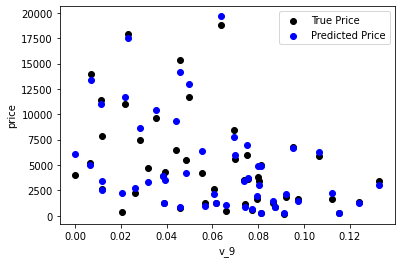

In [21]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

## 五折交叉验证

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [23]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [24]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [25]:
print('AVG:', np.mean(scores))

AVG: 1.3658024027229465


In [26]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [27]:
print('AVG:', np.mean(scores))

AVG: 0.19325301545987963


In [28]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


## 模拟真实业务

In [29]:
import datetime

In [30]:
sample_feature = sample_feature.reset_index(drop=True)

In [31]:
split_point = len(sample_feature) // 5 * 4

In [32]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [33]:
model = model.fit(train_X, train_y_ln)

In [34]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667051816935

## 绘制学习率曲线与验证曲线

In [36]:
from sklearn.model_selection import learning_curve, validation_curve

In [37]:
? learning_curve

Signature:
 learning_curve(
    estimator,
    X,
    y,
    *,
    groups=None,
    train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=None,
    pre_dispatch='all',
    verbose=0,
    shuffle=False,
    random_state=None,
    error_score=nan,
    return_times=False,
)
Docstring:
Learning curve.

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.

Read more in the :ref:`User Guide <learning_curve>`.

Parameters
----------
estimator : object type that implements the "fit" and "predict" methods
    An object of that type which is cloned 

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from '/home/yunwanx/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

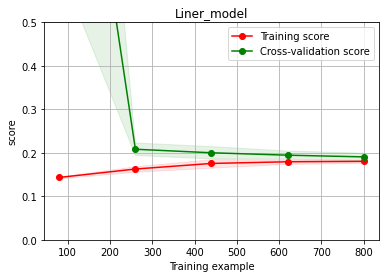

In [39]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [40]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [42]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [43]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [44]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.75074540766163


<AxesSubplot:>

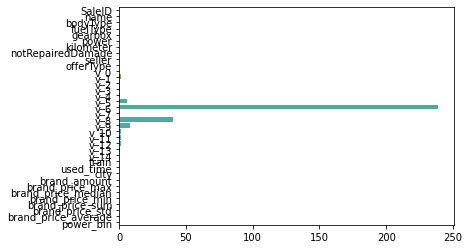

In [45]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.67171078236834


<AxesSubplot:>

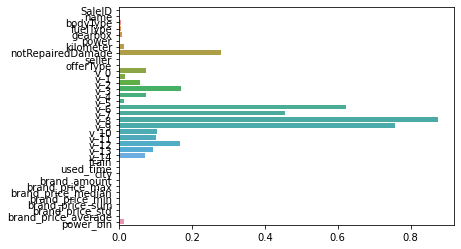

In [46]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182455737994


<AxesSubplot:>

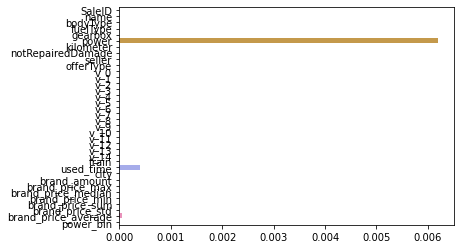

In [47]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
#from xgboost.sklearn import XGBRegressor
#from lightgbm.sklearn import LGBMRegressor

In [53]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
       #   XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
       #   LGBMRegressor(n_estimators = 100)
         ]

In [ ]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished


In [ ]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

In [ ]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [ ]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

In [ ]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [ ]:
clf.best_params_

In [ ]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [ ]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [ ]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [ ]:
rf_bo.maximize()

In [ ]:
1 - rf_bo.max['target']

In [ ]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])